Fit CNN in PyTorch
===


## Imports

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
from torchmetrics import R2Score
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
from skimage import io, transform
from glob import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 10

# size of test and validation set
n_test = 90

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 500
num_epochs_ft = 500

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5   
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 1 * 10 ** loglr
lr_ft = 0.0001

IMG_360 = '../sanders_2018/360 Rocks/'
IMG_120 = '../sanders_2018/120 Rocks/'
MDS_360 = '../finetuning_torchvision_data/mds_360.csv'
CHECKPOINTS = 'CNN_checkpoints/'
PATH_IM = CHECKPOINTS + 'state_dict_intermediate_model.pt'
PATH_FT = CHECKPOINTS + 'state_dict_finetuned_model.pt'

print("Device is", device)

Device is cuda


## Functions and classes

In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    r2score = R2Score(num_outputs=8).to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2score(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f} lr: {lr: .4e}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(datasets.VisionDataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        label = deepcopy(self.df.iloc[ix,1:].tolist())
        label = torch.tensor(label).float()
        img = self.preprocess_input(img)
        return img, label
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)    

    
class PredictionData(datasets.VisionDataset): # TODO: lots of redundant code. integrate this into above RocksData dataset
    def __init__(self, img_paths):
        super(PredictionData).__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.img_paths = img_paths
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, ix):
        img = cv2.imread(self.img_paths[ix])/255.
        img = self.preprocess_input(img)
        return img
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device) 
    
    
def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")

## Prepare Data

<div class="alert alert-warning" role="alert">Note: Stratified split still to be implemented!</div>

In [28]:
df = pd.read_csv(MDS_360)

train, test = train_test_split(df, test_size=n_test, random_state=0)
train, val = train_test_split(train, test_size=n_test, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), IMG_360)
val_dataset = RocksData(val.reset_index(drop=True), IMG_360)
test_dataset = RocksData(test.reset_index(drop=True), IMG_360)
pred_dataset = PredictionData(glob(IMG_120+'*.jpg'))

## Adapt model

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [29]:
def get_output_layers(dropout, num_ftrs, n_dim, n_layers):
    """
    Returns the output layers.
    """
   
    output = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, n_dense), # Dense layer in keras
            nn.ReLU(inplace=True), # Dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dense), # Dense
            nn.ReLU(inplace=True), # Dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dim) # Dense
        )
    
    return output

## Train ensemble

In [ ]:
for e in range(1, n_ensemble + 1):
       
    # Intermediate model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    set_parameter_requires_grad(model, feature_extract_im)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer
    
    # Send the model to GPU
    model = model.to(device)
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_im)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
    
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_im:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)

    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...


    # Instantiate optimizer for intermediate model
    optimizer = optim.Adam(params_to_update, lr = lr_im)
    
    # Setup the loss fxn
    criterion = get_criterion('L2')
    
    # Initial training and evaluate
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Intermediate model {e}')
    plt.show()
    
    # Save intermediate model
    torch.save(model.state_dict(), PATH_IM)

    # fine tuning
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)

## Load checkpoints and get predictions for validation and test sets

In [7]:
def load_pretrained_model(e):

    # Load intermediate model for finetuning
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_ft)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer

    # OPTIONAL: Load pre-trained state
    checkpoint = torch.load(CHECKPOINTS + f'state_dict_ensemble_model_{e+1}.pt')
    model.load_state_dict(checkpoint)

    # Send the model to GPU
    return model.to(device)


def predict(model, data_loader, unlabeled=False):
    """Computes predictions for a given mnodel and dataset"""
    
    model.eval()

    outputs = list()
    since = time.time()
    with torch.no_grad():
        if unlabeled:
            for inputs in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.squeeze().numpy())
        else:
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.squeeze().numpy())

    return np.array(outputs)

### Create dataloaders for inference

In [8]:
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

### Run ensemble models (CNNs) ...
... to collect their individual predictions

In [9]:
test_pred = []
rocks_120_pred = []

for e in range(n_ensemble):
    model = load_pretrained_model(e)
    test_pred.append(predict(model, test_loader))
    rocks_120_pred.append(predict(model, pred_loader, unlabeled=True))
    
test_pred = np.array(test_pred)

# OPTIONAL: may later be replaced by predictions of an optimized stacked ensemble
rocks_120_pred = np.array(rocks_120_pred)

### Run meta learner (LinearRegression, ElasticNet or similar) ...
... to find optimally weighted mean of CNN predictions.

$Y_{pred} =  b_0 + b_1 Y_{pred_1} + b_2 Y_{pred_2}$

But first we start simple ...

In [281]:
Y_test = test.iloc[:,1:].values

#### Check model predictions separately

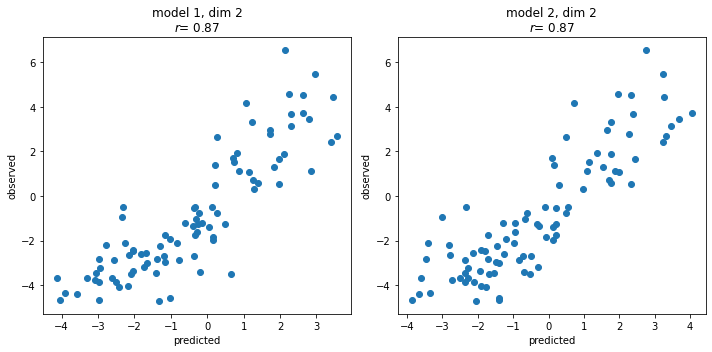

In [329]:
d_i = 2 # Dimension

fig, axs = plt.subplots(1,2, figsize=(10,5))

for e in range(n_ensemble):
    Y_pred_dim = test_pred[e][:, d_i-1]
    Y_dim = Y_test[:, d_i-1]
    corr = np.corrcoef(Y_pred_dim,Y_dim).min()

    axs[e].scatter(Y_pred_dim, Y_dim)
    axs[e].set_ylabel('observed')
    axs[e].set_xlabel('predicted')
    axs[e].set_title(f'model {e+1}, dim {d_i}\n$r$={corr: .2f}')

fig.tight_layout()

#### Check stacked model predictions

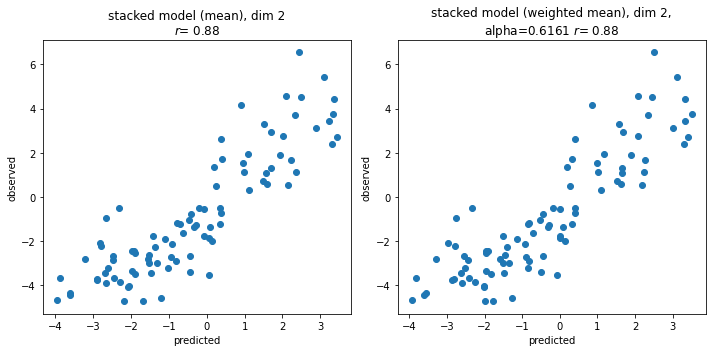

In [330]:
d_i = 2
alpha = 0.6161 # 0 we use only model 1, 1 we use only model 2, 0.5 is normal mean


fig, axs = plt.subplots(1,2, figsize=(10,5))

# mean plot
Y_pred_dim = np.mean(test_pred, 0)[:, d_i-1]
Y_dim = Y_test[:, d_i-1]
corr = np.corrcoef(Y_pred_dim,Y_dim).min()

axs[0].scatter(Y_pred_dim, Y_dim)
axs[0].set_ylabel('observed')
axs[0].set_xlabel('predicted')
axs[0].set_title(f'stacked model (mean), dim {d_i}\n$r$={corr: .2f}')

# weighted mean plot
Y_pred_dim = (test_pred[0]*(1-alpha) + test_pred[1]*alpha)[:, d_i-1]
Y_dim = Y_test[:, d_i-1]
corr = np.corrcoef(Y_pred_dim,Y_dim).min()

axs[1].scatter(Y_pred_dim, Y_dim)
axs[1].set_ylabel('observed')
axs[1].set_xlabel('predicted')
axs[1].set_title(f'stacked model (weighted mean), dim {d_i},\nalpha={alpha} $r$={corr: .2f}');

fig.tight_layout()

#### finding optimal alpha across dimensions ...
... using $R²$ score

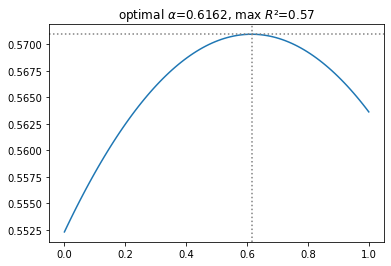

In [311]:
alpha_space = np.linspace(0,1,100)
scores = []
for alpha in alpha_space:
    preds_1 = test_pred[0, :, :] * (1-alpha)
    preds_2 = test_pred[1, :, :] * (alpha)
    Y_pred_dim = test_pred[0]*(1-alpha) + test_pred[1]*alpha
    Y_dim = Y_test
    score = r2_score(Y_dim, Y_pred_dim)
    scores.append([alpha, score])
scores = np.array(scores)

optimal_alpha, max_score = scores[scores.T[1].argmax()]

plt.plot(scores[:, 0], scores[:, 1])
plt.axvline(optimal_alpha, c='gray', linestyle=':')
plt.axhline(max_score, c='gray', linestyle=':')
plt.title(rf'optimal $\alpha$={optimal_alpha:.4f}, max $R²$={max_score:.2f}');

**According to their paper Sanders & Nosofsky were not using a meta-learner, they were training an ensemble of 10 models and averaging them.**

In [277]:
# Simplest method: compute mean of all ensemble models
#test_prediction = np.mean(test_pred, 0)
#rocks_120_prediction = np.mean(rocks_120_pred, 0)

# Less simple method: compute weighted mean
rocks_120_prediction = (rocks_120_pred[0] * (1-alpha)) + (rocks_120_pred[1] * (alpha))

# May best: fitting a linear model?

### Get MSE

In [278]:
# get labels
Y_120 = np.loadtxt("../sanders_2018/mds_120.txt")
Y_validate = train.iloc[:, 1:].values
Y_test = test.iloc[:, 1:].values

In [279]:
print(mean_squared_error(Y_test, test_prediction))
print(mean_squared_error(Y_120, rocks_120_prediction))

2.563432885549675
5.15055916865052


### Get R²

In [280]:
print(r2_score(Y_test, test_prediction))
print(r2_score(Y_120, rocks_120_prediction))

0.570286529742091
-1.3208727376565275


### Save predictions to file

In [17]:
np.savetxt("CNN Predictions/MDS Dimensions/cnn_torch_predicted_mds_120.txt", rocks_120_prediction)